In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Initial Exploration

In [2]:
data = pd.read_csv('tiktok_dataset.csv')

In [3]:
data.head(10)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0
5,6,claim,8972200955,35,someone shared with me that gross domestic pro...,not verified,under review,336647.0,175546.0,62303.0,4293.0,1857.0
6,7,claim,4958886992,16,someone shared with me that elvis presley has ...,not verified,active,750345.0,486192.0,193911.0,8616.0,5446.0
7,8,claim,2270982263,41,someone shared with me that the best selling s...,not verified,active,547532.0,1072.0,50.0,22.0,11.0
8,9,claim,5235769692,50,someone shared with me that about half of the ...,not verified,active,24819.0,10160.0,1050.0,53.0,27.0
9,10,claim,4660861094,45,someone shared with me that it would take a 50...,verified,active,931587.0,171051.0,67739.0,4104.0,2540.0


In [ ]:
#Cleaning

In [43]:
df = data.copy()

In [55]:
# numeric → fill NaN with 0
num_cols_clean = [
    "video_duration_sec",
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count",
]
df[num_cols_clean] = df[num_cols_clean].apply(pd.to_numeric, errors="coerce").fillna(0)

In [56]:
# categorical → lowercase/strip, fill NaN with "unknown"
category_cols = ["claim_status", "verified_status", "author_ban_status"]
for c in category_cols:
    df[c] = df[c].astype(str).str.lower().str.strip().replace({"nan": np.nan}).fillna("unknown")

# text → fill NaN with empty string
if "video_transcription_text" in df.columns:
    df["video_transcription_text"] = df["video_transcription_text"].fillna("").astype(str)

In [47]:
print("Cleaned shape:", df.shape)
df.head(5)

Cleaned shape: (19382, 12)


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [58]:
# Check for zero values in key numeric columns
num_cols_check_zeros = [
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count"]

(df[num_cols_check_zeros] == 0).sum()

video_view_count         298
video_like_count         302
video_share_count        397
video_download_count    1275
video_comment_count     3732
dtype: int64

In [ ]:
#building new columns

In [49]:
# Engagement ratios
df["engagement_rate"] = ((df["video_like_count"] + df["video_share_count"] + df["video_comment_count"] + df["video_download_count"])/ df["video_view_count"])

df["like_ratio"] = df["video_like_count"] / df["video_view_count"]
df["share_ratio"] = df["video_share_count"] / df["video_view_count"]
df["comment_ratio"] = df["video_comment_count"] / df["video_view_count"]

# Handle div/0 → replace inf/nan with 0
ratio_cols = ["engagement_rate","like_ratio","share_ratio","comment_ratio"]
df[ratio_cols] = df[ratio_cols].replace([np.inf, -np.inf], 0).fillna(0)

df[ratio_cols].describe()

,engagement_rate,like_ratio,share_ratio,comment_ratio
count,19382.000000,19382.000000,19382.000000,19382.000000
mean,0.330185,0.271848,0.054016,0.000940
std,0.215535,0.175000,0.050658,0.001321
min,0.000000,0.000000,0.000000,0.000000
25%,0.150308,0.124517,0.013514,0.000077
50%,0.312783,0.259708,0.038864,0.000440
75%,0.477160,0.396364,0.081017,0.001245
max,0.935961,0.666648,0.265956,0.010280


In [51]:
# Video length buckets
"""
raw video_duration_sec is numeric, but length often has a non-linear effect:
Very short videos (<20s): often optimized for virality.
Medium (20–40s): typical TikTok range.
Long (>40s): less common, might affect engagement differently.

By bucketing, there is another categorical feature that models can use directly.
It helps simplify patterns instead of treating every second as unique.
"""
def bucket_length(x):
    if x < 20:
        return "short"
    elif x <= 40:
        return "medium"
    else:
        return "long"

df["video_length_bucket"] = df["video_duration_sec"].apply(bucket_length)

df["video_length_bucket"].value_counts()

video_length_bucket
medium    7211
long      6932
short     5239
Name: count, dtype: int64

In [53]:
# Boolean encodings - turns categorical flags into 0/1 dummy variables.
df["is_claim"] = (df["claim_status"] == "claim").astype(int)
df["is_verified"] = (df["verified_status"] == "verified").astype(int)
df["is_author_banned"] = (df["author_ban_status"] == "banned").astype(int)

df[["claim_status","is_claim","verified_status","is_verified","author_ban_status","is_author_banned"]].head(10)

,claim_status,is_claim,verified_status,is_verified,author_ban_status,is_author_banned
0,claim,1,not verified,0,under review,0
1,claim,1,not verified,0,active,0
2,claim,1,not verified,0,active,0
3,claim,1,not verified,0,active,0
4,claim,1,not verified,0,active,0
5,claim,1,not verified,0,under review,0
6,claim,1,not verified,0,active,0
7,claim,1,not verified,0,active,0
8,claim,1,not verified,0,active,0
9,claim,1,verified,1,active,0


In [54]:
# Phase 1 summary (engineered columns only)
engineered_cols = ["engagement_rate", "like_ratio", "share_ratio", "comment_ratio","video_length_bucket",
    "is_claim", "is_verified", "is_author_banned"]

print("Phase 1 complete. Engineered columns created:\n", engineered_cols)

df.head(3)

Phase 1 complete. Engineered columns created:
 ['engagement_rate', 'like_ratio', 'share_ratio', 'comment_ratio', 'video_length_bucket', 'is_claim', 'is_verified', 'is_author_banned']


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,engagement_rate,like_ratio,share_ratio,comment_ratio,video_length_bucket,is_claim,is_verified,is_author_banned
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.057289,0.056584,0.000702,0.000000,long,1,0,0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.697303,0.549096,0.135111,0.004855,medium,1,0,0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.112737,0.108282,0.003168,0.000365,medium,1,0,0


In [ ]:
#Visualizations

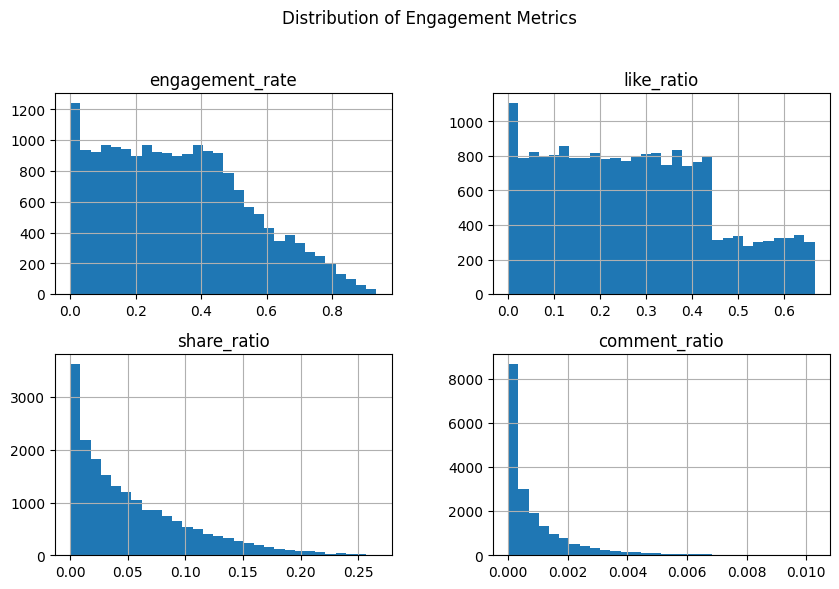

In [16]:
# Histograms of engagement metrics
engagement_cols = ["engagement_rate", "like_ratio", "share_ratio", "comment_ratio"]

df[engagement_cols].hist(bins=30, figsize=(10,6))
plt.suptitle("Distribution of Engagement Metrics", y=1.02)
plt.show()

In [17]:
"""
engagement_rate: fairly spread between 0–0.9, mean around 0.33.
like_ratio: main driver, spread fairly evenly up to ~0.6.
share_ratio: very right-skewed — most videos have tiny share rates, a few outliers get big shares.
comment_ratio: extremely right-skewed — almost all videos have very low comment ratios.
"""

'\nengagement_rate: fairly spread between 0–0.9, mean around 0.33.\nlike_ratio: main driver, spread fairly evenly up to ~0.6.\nshare_ratio: very right-skewed — most videos have tiny share rates, a few outliers get big shares.\ncomment_ratio: extremely right-skewed — almost all videos have very low comment ratios.\n'

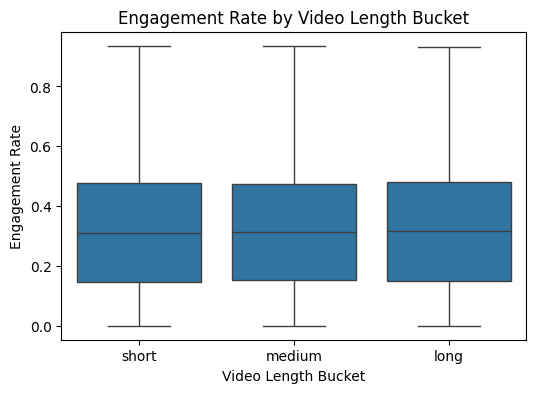

In [92]:
# Boxplot of engagement by video length bucket
plt.figure(figsize=(6,4))
sns.boxplot(x="video_length_bucket", y="engagement_rate", data=df, order=["short","medium","long"])
plt.title("Engagement Rate by Video Length Bucket")
plt.xlabel("Video Length Bucket")
plt.ylabel("Engagement Rate")
plt.show()

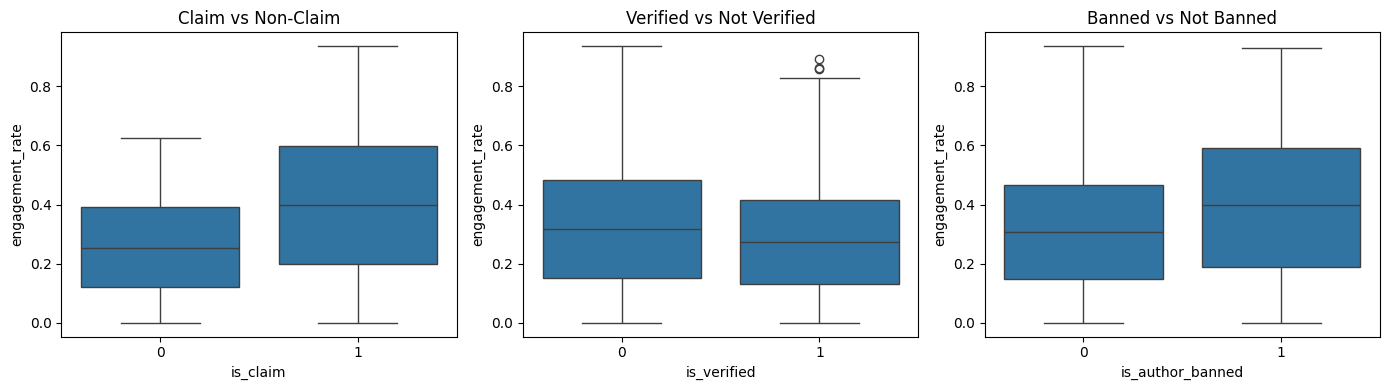

In [18]:
# Boxplots: engagement_rate by claim / verified / banned
fig, axes = plt.subplots(1, 3, figsize=(14,4))

sns.boxplot(x="is_claim", y="engagement_rate", data=df, ax=axes[0])
axes[0].set_title("Claim vs Non-Claim")

sns.boxplot(x="is_verified", y="engagement_rate", data=df, ax=axes[1])
axes[1].set_title("Verified vs Not Verified")

sns.boxplot(x="is_author_banned", y="engagement_rate", data=df, ax=axes[2])
axes[2].set_title("Banned vs Not Banned")

plt.tight_layout()
plt.show()

In [19]:
"""
Claims: visibly higher median engagement compared to non-claims.
Verified: engagement looks slightly lower than non-verified (opposite of what you might expect).
Banned Authors: higher median engagement than non-banned.
Claims and controversial/banned content may attract higher engagement, verified status doesn’t guarantee it.
"""

'\nClaims: visibly higher median engagement compared to non-claims.\nVerified: engagement looks slightly lower than non-verified (opposite of what you might expect).\nBanned Authors: higher median engagement than non-banned.\nClaims and controversial/banned content may attract higher engagement, verified status doesn’t guarantee it.\n'

In [20]:
# Grouped summary (mean & median engagement)
summary = pd.DataFrame({
    "is_claim_mean": df.groupby("is_claim")["engagement_rate"].mean(),
    "is_claim_median": df.groupby("is_claim")["engagement_rate"].median(),
    "is_verified_mean": df.groupby("is_verified")["engagement_rate"].mean(),
    "is_verified_median": df.groupby("is_verified")["engagement_rate"].median(),
    "is_author_banned_mean": df.groupby("is_author_banned")["engagement_rate"].mean(),
    "is_author_banned_median": df.groupby("is_author_banned")["engagement_rate"].median(),
}).T

summary

,0,1
is_claim_mean,0.258598,0.403009
is_claim_median,0.253274,0.396782
is_verified_mean,0.333439,0.282577
is_verified_median,0.316015,0.273611
is_author_banned_mean,0.323971,0.397449
is_author_banned_median,0.307420,0.398040


In [21]:
"""
is_claim_mean: ~0.40 vs 0.25 → claims boost engagement.
is_verified_mean: 0.28 vs 0.33 → verified slightly underperforms.
is_author_banned_mean: 0.39 vs 0.32 → banned authors’ videos attract more engagement.
"""

'\nis_claim_mean: ~0.40 vs 0.25 → claims boost engagement.\nis_verified_mean: 0.28 vs 0.33 → verified slightly underperforms.\nis_author_banned_mean: 0.39 vs 0.32 → banned authors’ videos attract more engagement.\n'

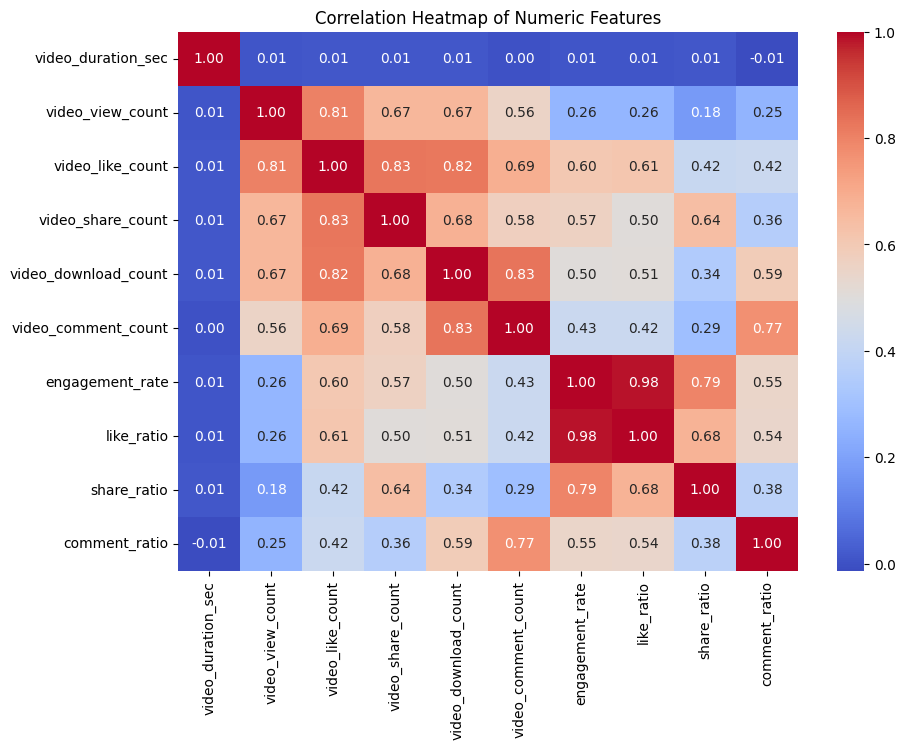

In [22]:
# Correlation heatmap (numeric features)
numeric_cols = [
    "video_duration_sec",
    "video_view_count",
    "video_like_count",
    "video_share_count",
    "video_download_count",
    "video_comment_count",
    "engagement_rate", "like_ratio", "share_ratio", "comment_ratio"
]

plt.figure(figsize=(10,7))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [23]:
"""
Strong correlations between views, likes, shares, downloads, comments (as expected — big videos get more of everything).
engagement_rate ≈ like_ratio (0.98).
Shares and comments are moderately correlated with engagement.
video_duration_sec has almost no correlation with anything.
Interpretation: video length has little predictive value.
"""

'\nStrong correlations between views, likes, shares, downloads, comments (as expected — big videos get more of everything).\nengagement_rate ≈ like_ratio (0.98).\nShares and comments are moderately correlated with engagement.\nvideo_duration_sec has almost no correlation with anything.\nInterpretation: video length has little predictive value.\n'

In [24]:
# Top correlations with engagement_rate
target_corr = (df[numeric_cols].corr()["engagement_rate"].drop("engagement_rate").sort_values(ascending=False))

print("Correlations with engagement_rate:\n")
print(target_corr)

Correlations with engagement_rate:

like_ratio              0.984860
share_ratio             0.794933
video_like_count        0.604124
video_share_count       0.567732
comment_ratio           0.546022
video_download_count    0.503973
video_comment_count     0.425393
video_view_count        0.260231
video_duration_sec      0.010066
Name: engagement_rate, dtype: float64


In [26]:
"""
like_ratio almost fully explains engagement_rate (since it’s a big component).
share_ratio adds extra predictive power.
raw counts (likes, shares, downloads) are moderately useful.
views (0.26) and duration (0.01) aren’t useful predictors.
Interpretation: when modeling engagement, focus on ratios, not raw counts or duration
"""

'\nlike_ratio almost fully explains engagement_rate (since it’s a big component).\nshare_ratio adds extra predictive power.\nraw counts (likes, shares, downloads) are moderately useful.\nviews (0.26) and duration (0.01) aren’t useful predictors.\nInterpretation: when modeling engagement, focus on ratios, not raw counts or duration\n'

In [27]:
#Avg likes, shares, comments by claim_status
cols = ["video_like_count", "video_share_count", "video_comment_count", "engagement_rate"]

claim_opinion_summary = (df.groupby("claim_status")[cols].mean().round(3))

print("Average engagement metrics by claim_status:")
display(claim_opinion_summary)

Average engagement metrics by claim_status:


,video_like_count,video_share_count,video_comment_count,engagement_rate
claim_status,,,,
claim,166373.331,33026.416,691.165,0.403
opinion,1092.730,217.146,2.697,0.267
unknown,0.000,0.000,0.000,0.000


In [31]:
"""
claim videos: very high avg likes (~166k), shares (~33k), comments (~691), engagement_rate ~0.40.
opinion videos: much lower likes (~1k), shares (~217), comments (~2.7), engagement_rate ~0.27.
unknown: basically empty / 0.

Interpretation: Claim videos are far more viral in terms of raw reach (likes, shares, comments). 
They also maintain a higher engagement rate than opinion content.
"""

'\nclaim videos: very high avg likes (~166k), shares (~33k), comments (~691), engagement_rate ~0.40.\nopinion videos: much lower likes (~1k), shares (~217), comments (~2.7), engagement_rate ~0.27.\nunknown: basically empty / 0.\n\nInterpretation: Claim videos are far more viral in terms of raw reach (likes, shares, comments). \nThey also maintain a higher engagement rate than opinion content.\n'

In [28]:
# Engagement ratios by claim_status (mean)
ratio_cols = ["like_ratio", "share_ratio", "comment_ratio"]

claim_opinion_ratios = df.groupby("claim_status")[ratio_cols].mean().round(3)

print("Engagement ratios by claim_status:")
display(claim_opinion_ratios)

Engagement ratios by claim_status:


,like_ratio,share_ratio,comment_ratio
claim_status,,,
claim,0.332,0.066,0.001
opinion,0.220,0.044,0.001
unknown,0.000,0.000,0.000


In [32]:
"""
Even after normalizing by views, claims outperform opinions. 
People like and share claims more frequently than opinions. Comments ratio is tiny in both groups but similar.
"""

'\nEven after normalizing by views, claims outperform opinions. \nPeople like and share claims more frequently than opinions. Comments ratio is tiny in both groups but similar.\n'

In [29]:
# Compare engagement by author_ban_status (all categories)
ban_summary = df.groupby("author_ban_status")["engagement_rate"].describe().round(3)

print("Engagement by author_ban_status:")
display(ban_summary)

Engagement by author_ban_status:


,count,mean,std,min,25%,50%,75%,max
author_ban_status,,,,,,,,
active,15663.0,0.318,0.209,0.0,0.144,0.302,0.460,0.936
banned,1639.0,0.397,0.239,0.0,0.190,0.398,0.592,0.930
under review,2080.0,0.369,0.229,0.0,0.176,0.353,0.539,0.915


In [ ]:
"""
active: ~0.32 mean engagement.
under review: ~0.37 mean engagement.
banned: ~0.40 mean engagement.

Interpretation:
There’s a clear pattern — the more restricted the account status, the higher the engagement rate. 
This suggests that highly viral (and perhaps controversial) videos are more likely to trigger review/bans.
"""

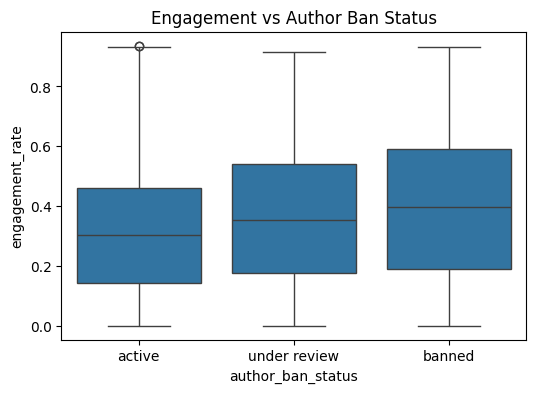

In [30]:
# visualizes engagement distribution by moderation category.
#confirms the numerical pattern visually — “under review” and “banned” videos skew higher in engagement.
plt.figure(figsize=(6,4))
sns.boxplot(x="author_ban_status", y="engagement_rate", data=df,
            order=["active","under review","banned"])
plt.title("Engagement vs Author Ban Status")
plt.show()

In [33]:
"""
Visually confirms the summary stats. High-engagement videos cluster more in “under review” and “banned,” 
suggesting a link between virality and moderation risk.
"""

'\nVisually confirms the summary stats. High-engagement videos cluster more in “under review” and “banned,” \nsuggesting a link between virality and moderation risk.\n'

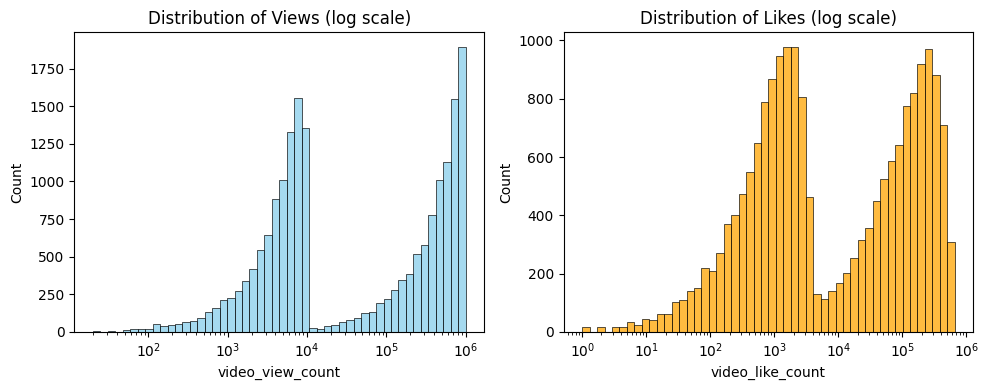

In [34]:
# Distribution of views & likes (log scale)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(df["video_view_count"], bins=50, log_scale=True, color="skyblue")
plt.title("Distribution of Views (log scale)")

plt.subplot(1,2,2)
sns.histplot(df["video_like_count"], bins=50, log_scale=True, color="orange")
plt.title("Distribution of Likes (log scale)")

plt.tight_layout()
plt.show()

In [35]:
#Top N most engaging videos
top_videos = (df.sort_values("engagement_rate", ascending=False)
      [["video_id","claim_status","author_ban_status","engagement_rate","video_view_count"]]
      .head(10))

print("Top 10 most engaging videos:")
display(top_videos)

Top 10 most engaging videos:


,video_id,claim_status,author_ban_status,engagement_rate,video_view_count
736,3218561174,claim,active,0.935961,702492.0
5711,7572100502,claim,active,0.935472,882170.0
1685,6717162038,claim,active,0.932428,242674.0
5569,4362264829,claim,active,0.930334,97178.0
8892,8261213140,claim,active,0.930122,306060.0
7063,2320027652,claim,banned,0.929924,623950.0
7385,4320338657,claim,active,0.929563,274685.0
1322,8405710607,claim,banned,0.928940,993156.0
8458,9521485000,claim,banned,0.928389,534971.0
6375,4875941763,claim,active,0.925579,184342.0


In [36]:
# Crosstab of claim_status vs author_ban_status
ct = pd.crosstab(df["claim_status"], df["author_ban_status"], normalize="index").round(3)

print("Proportion of ban statuses within each claim_status group:")
display(ct)

Proportion of ban statuses within each claim_status group:


author_ban_status,active,banned,under review
claim_status,,,
claim,0.683,0.150,0.167
opinion,0.930,0.021,0.049
unknown,0.940,0.013,0.047


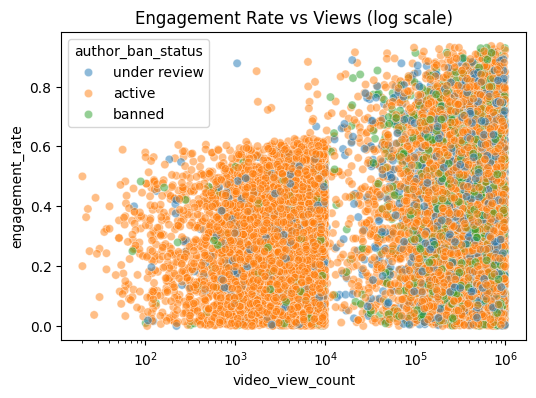

High-engagement outliers (>0.9):


,video_id,claim_status,author_ban_status,engagement_rate,video_view_count
6,4958886992,claim,active,0.925128,750345.0
647,1497295906,claim,under review,0.915277,738552.0
736,3218561174,claim,active,0.935961,702492.0
1199,1613860309,claim,active,0.916779,813173.0
1322,8405710607,claim,banned,0.928940,993156.0
1685,6717162038,claim,active,0.932428,242674.0
1899,9661806287,claim,active,0.902088,119311.0
2141,7893577997,claim,active,0.911740,336357.0
2159,5621844846,claim,banned,0.911070,619501.0
2313,4292060939,claim,banned,0.903044,916347.0


In [40]:
# Outlier detection (views vs engagement_rate)
plt.figure(figsize=(6,4))
sns.scatterplot(x="video_view_count", y="engagement_rate", hue="author_ban_status", 
                data=df, alpha=0.5)
plt.xscale("log")
plt.title("Engagement Rate vs Views (log scale)")
plt.show()

# Check outliers
outliers = df[df["engagement_rate"] > 0.9][["video_id","claim_status","author_ban_status","engagement_rate","video_view_count"]]
print("High-engagement outliers (>0.9):")
display(outliers.head(10))

In [ ]:
#Building ML Models

In [ ]:
"""
Build Features & Targets
1. Create new helper features (transcript_length).
2. Define X, y for each task:
        Virality → y_reg = engagement_rate.
        Ban Risk → y_risk = 1 if author_ban_status in {under review, banned} else 0.
        Claim Detector → y_claim = claim_status (binary claim vs opinion; we’ll ignore “unknown” for now).
3. Drop leakage features (like ratios when predicting engagement).
4. Train/test split for each task.
"""

In [80]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import re

In [59]:
# Feature engineering for modeling

# --- Helper feature: transcript length
df["transcript_length"] = df["video_transcription_text"].apply(len)

# ---  Virality (regression)
X_reg = df[[
    "video_duration_sec","video_view_count","video_like_count","video_share_count",
    "video_download_count","video_comment_count","is_claim","is_verified",
    "is_author_banned","transcript_length"
]].copy()
y_reg = df["engagement_rate"]

# --- Ban Risk (classification: active vs under_review/banned)
df["ban_risk_binary"] = df["author_ban_status"].isin(["under review","banned"]).astype(int)
X_risk = df[[
    "video_duration_sec","video_view_count","video_like_count","video_share_count",
    "video_download_count","video_comment_count","like_ratio","share_ratio","comment_ratio",
    "is_claim","is_verified","transcript_length"
]].copy()
y_risk = df["ban_risk_binary"]

# --- Claim Detector (classification: claim vs opinion only)
df_claim = df[df["claim_status"].isin(["claim","opinion"])].copy()
X_claim = df_claim[[
    "video_duration_sec","video_view_count","video_like_count","video_share_count",
    "video_download_count","video_comment_count","like_ratio","share_ratio","comment_ratio",
    "is_verified","is_author_banned","transcript_length"]].copy()
y_claim = (df_claim["claim_status"] == "claim").astype(int)

# --- Train/Test splits
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

X_risk_train, X_risk_test, y_risk_train, y_risk_test = train_test_split(
    X_risk, y_risk, test_size=0.2, stratify=y_risk, random_state=42)

X_claim_train, X_claim_test, y_claim_train, y_claim_test = train_test_split(
    X_claim, y_claim, test_size=0.2, stratify=y_claim, random_state=42)

print("Feature matrices & targets ready:")
print("Virality:", X_reg_train.shape, "→", y_reg_train.shape)
print("Ban Risk:", X_risk_train.shape, "→", y_risk_train.shape)
print("Claim Detector:", X_claim_train.shape, "→", y_claim_train.shape)

Feature matrices & targets ready:
Virality: (15505, 10) → (15505,)
Ban Risk: (15505, 12) → (15505,)
Claim Detector: (15267, 12) → (15267,)


In [ ]:
"""
Baseline Models
For Virality → Linear Regression.
For Ban Risk → Classification.
For Claim Detector → Classification.

This gives a “floor” to compare tree models against.
"""

In [93]:
# --- 1. Virality: Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_reg_train, y_reg_train)
y_virality_pred = lin_reg.predict(X_reg_test)

print("Virality — Linear Regression")
print("  RMSE:", mean_squared_error(y_reg_test, y_virality_pred, squared=False))
print("  MAE :", mean_absolute_error(y_reg_test, y_virality_pred))
print("  R^2 :", r2_score(y_reg_test, y_virality_pred))
print()

Virality — Linear Regression
  RMSE: 0.1386298178019172
  MAE : 0.11006018229324865
  R^2 : 0.5762181866735308



C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
"""
RMSE = 0.1386 → average error ~14 percentage points in engagement rate.
MAE = 0.1100 → typical error ~11 percentage points.
R² = 0.576 → explains ~58% of the variance in engagement.
- improvement will be done by Random Forests & XGBoost as they should capture nonlinear effects better.
"""

In [94]:
# --- 2. Ban Risk: Logistic Regression
log_risk = LogisticRegression(max_iter=1000, class_weight="balanced")
log_risk.fit(X_risk_train, y_risk_train)
y_banrisk_pred = log_risk.predict(X_risk_test)

print("Ban Risk — Logistic Regression")
print(classification_report(y_risk_test, y_banrisk_pred))
print("Confusion Matrix:\n", confusion_matrix(y_risk_test, y_banrisk_pred))
print()

Ban Risk — Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.59      0.72      3133
           1       0.32      0.81      0.46       744

    accuracy                           0.63      3877
   macro avg       0.63      0.70      0.59      3877
weighted avg       0.81      0.63      0.67      3877

Confusion Matrix:
 [[1855 1278]
 [ 138  606]]



C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
"""
Precision (class 1, risky) = 0.32 → many false positives.
Recall (class 1) = 0.81 → catches most risky videos.
Accuracy = 0.63 overall.

Confusion Matrix shows it misses a lot of actives (predicts risky too often).
- model is skewed toward recall (good for catching risky content), but tradeoff is low precision
"""

In [63]:
# --- 3. Claim Detector: Logistic Regression
log_claim = LogisticRegression(max_iter=1000, class_weight="balanced")
log_claim.fit(X_claim_train, y_claim_train)
y_claim_pred = log_claim.predict(X_claim_test)

print("Claim Detector — Logistic Regression")
print(classification_report(y_claim_test, y_claim_pred))
print("Confusion Matrix:\n", confusion_matrix(y_claim_test, y_claim_pred))

Claim Detector — Logistic Regression
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1895
           1       1.00      0.99      0.99      1922

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817

Confusion Matrix:
 [[1895    0]
 [  24 1898]]


C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
"""
Accuracy = 0.99, F1 ≈ 0.99 for both classes.
- Very clean separation: almost perfect classification of claim vs opinion.

Note: this task is probably very easy — maybe “opinion” rows have distinct features (like lower counts/ratios). Still, a nice strong baseline.
"""

In [ ]:
#baseline models done, now move to randomforest

In [64]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

Virality — Random Forest
  RMSE: 0.014444679152711127
  MAE : 0.008433386732435858
  R^2 : 0.9953990786493024


C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


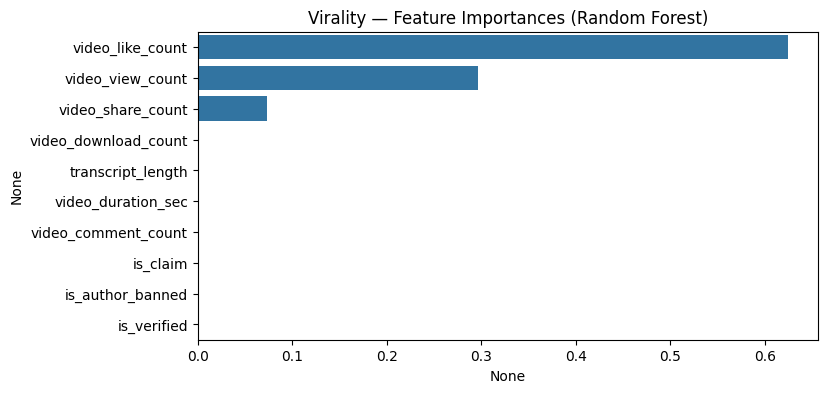

video_like_count        0.624761
video_view_count        0.296742
video_share_count       0.073115
video_download_count    0.001355
transcript_length       0.001101
video_duration_sec      0.001081
video_comment_count     0.001055
is_claim                0.000632
is_author_banned        0.000112
is_verified             0.000048
dtype: float64


In [97]:
# --- 1. Virality: Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_reg.fit(X_reg_train, y_reg_train)
y_virality_pred_rf = rf_reg.predict(X_reg_test)   # renamed variable

print("Virality — Random Forest")
print("  RMSE:", mean_squared_error(y_reg_test, y_virality_pred_rf, squared=False))
print("  MAE :", mean_absolute_error(y_reg_test, y_virality_pred_rf))
print("  R^2 :", r2_score(y_reg_test, y_virality_pred_rf))

# --- Feature importance for virality
importances_virality_rf = pd.Series(rf_reg.feature_importances_, index=X_reg_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances_virality_rf, y=importances_virality_rf.index)
plt.title("Virality — Feature Importances (Random Forest)")
plt.show()
print(importances_virality_rf)

In [ ]:
"""
1. Virality (Random Forest Regressor)
RMSE = 0.0144 vs 0.1386 (linear baseline) → huge improvement.
MAE = 0.0084 → errors are less than 1 percentage point.
R² = 0.995 → explains ~99.5% of variance (almost perfect fit).

Feature importances:
video_like_count (62%) and video_view_count (30%) dominate → basically, likes and views are what drive engagement rate predictions.
Shares and downloads add a little, everything else (claims, transcript length, verified) has almost no impact.

So, RF is almost overfitting here, because engagement_rate is mathematically tied to likes/views. 
"""


Ban Risk — Random Forest
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3133
           1       0.37      0.02      0.04       744

    accuracy                           0.81      3877
   macro avg       0.59      0.51      0.47      3877
weighted avg       0.73      0.81      0.73      3877

Confusion Matrix:
 [[3104   29]
 [ 727   17]]


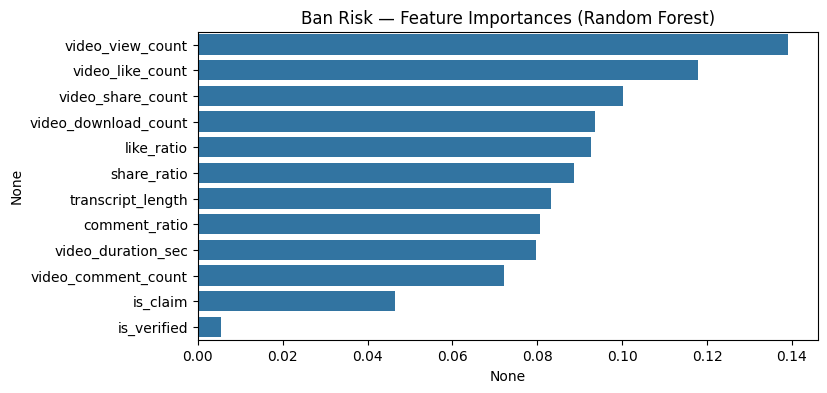

video_view_count        0.139147
video_like_count        0.117873
video_share_count       0.100125
video_download_count    0.093691
like_ratio              0.092583
share_ratio             0.088746
transcript_length       0.083181
comment_ratio           0.080666
video_duration_sec      0.079807
video_comment_count     0.072223
is_claim                0.046553
is_verified             0.005405
dtype: float64


In [98]:
# --- 2. Ban Risk: Random Forest Classifier
rf_risk = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1)
rf_risk.fit(X_risk_train, y_risk_train)
y_banrisk_pred_rf = rf_risk.predict(X_risk_test)   # renamed variable

print("\nBan Risk — Random Forest")
print(classification_report(y_risk_test, y_banrisk_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_risk_test, y_banrisk_pred_rf))

# --- Feature importance for ban risk
importances_banrisk_rf = pd.Series(rf_risk.feature_importances_, index=X_risk_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances_banrisk_rf, y=importances_banrisk_rf.index)
plt.title("Ban Risk — Feature Importances (Random Forest)")
plt.show()
print(importances_banrisk_rf)

In [ ]:
"""
Accuracy = 0.81 (big jump from 0.63 with logistic regression).
Class 1 (risky) still weak: precision = 0.37, recall = 0.02.
Model basically predicts almost everything as “safe.”

Feature importances:
Top: video_view_count, video_like_count, video_share_count, video_download_count.
Ratios (like_ratio, share_ratio) also matter.
Text length, claim flag, verified have small but nonzero influence.

ban-risk is genuinely hard — engagement signals dominate, but they don’t perfectly separate flagged vs safe. 
Might need gradient boosting (XGB/LightGBM) or even NLP features from transcript to capture the nuance.

"""


Claim Detector — Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1895
           1       1.00      0.99      1.00      1922

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

Confusion Matrix:
 [[1895    0]
 [  11 1911]]


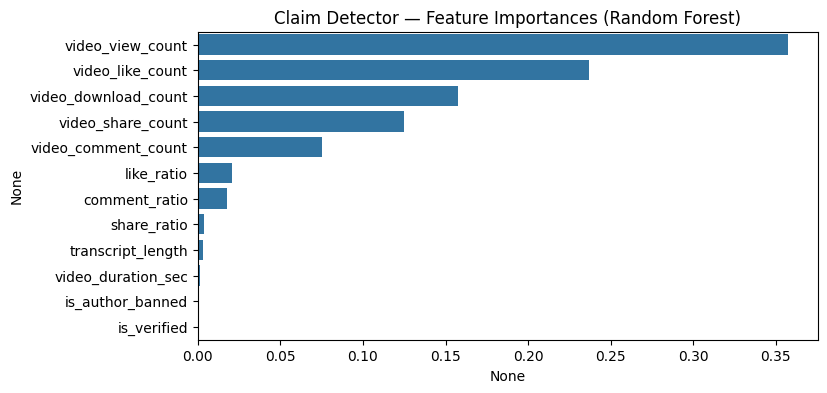

video_view_count        0.357517
video_like_count        0.236720
video_download_count    0.157686
video_share_count       0.124879
video_comment_count     0.075166
like_ratio              0.021005
comment_ratio           0.017791
share_ratio             0.003900
transcript_length       0.003205
video_duration_sec      0.001255
is_author_banned        0.000853
is_verified             0.000023
dtype: float64


In [99]:
# --- 3. Claim Detector: Random Forest Classifier
rf_claim = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1)
rf_claim.fit(X_claim_train, y_claim_train)
y_claim_pred_rf = rf_claim.predict(X_claim_test)   # renamed variable

print("\nClaim Detector — Random Forest")
print(classification_report(y_claim_test, y_claim_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_claim_test, y_claim_pred_rf))

# --- Feature importance for claim detector
importances_claim_rf = pd.Series(rf_claim.feature_importances_, index=X_claim_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=importances_claim_rf, y=importances_claim_rf.index)
plt.title("Claim Detector — Feature Importances (Random Forest)")
plt.show()
print(importances_claim_rf)

In [ ]:
"""
Accuracy ~1.00, F1 ~1.00 (same as logistic regression, but equally strong).
Confusion matrix → virtually no misclassifications.

Feature importances:
Top drivers: video_view_count, video_like_count, video_download_count, video_share_count.
Ratios (like_ratio, comment_ratio) matter much less.
Verified status adds nothing.

claims vs opinions are strongly separated just by scale of engagement — claims consistently get more interaction.
"""

In [ ]:
#xgboost ML models

In [72]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\veera\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [74]:
from xgboost import XGBRegressor, XGBClassifier, plot_importance

Virality — XGBoost
  RMSE: 0.01414905697571097
  MAE : 0.008750027979480756
  R^2 : 0.9955854747942297


C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


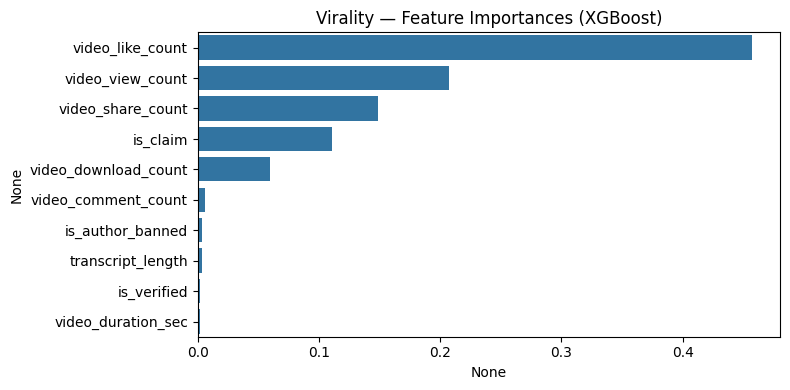

video_like_count        0.457462
video_view_count        0.206962
video_share_count       0.149017
is_claim                0.111086
video_download_count    0.059265
video_comment_count     0.005640
is_author_banned        0.003569
transcript_length       0.003072
is_verified             0.002021
video_duration_sec      0.001905
dtype: float32


In [100]:
# -------------------------------
# 1) Virality — XGBRegressor
# -------------------------------
xgb_reg = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.0,
    tree_method="hist")
xgb_reg.fit(X_reg_train, y_reg_train)
y_virality_pred_xgb = xgb_reg.predict(X_reg_test)

print("Virality — XGBoost")
print("  RMSE:", mean_squared_error(y_reg_test, y_virality_pred_xgb, squared=False))
print("  MAE :", mean_absolute_error(y_reg_test, y_virality_pred_xgb))
print("  R^2 :", r2_score(y_reg_test, y_virality_pred_xgb))

# Feature importance
virality_reg = pd.Series(xgb_reg.feature_importances_, index=X_reg_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=imp_reg, y=imp_reg.index)
plt.title("Virality — Feature Importances (XGBoost)")
plt.tight_layout(); plt.show()
print(virality_reg)

In [ ]:
"""
1. Virality (XGBoost Regressor)
RMSE = 0.0141, MAE = 0.0088, R² = 0.9959
→ nearly identical to Random Forest. confirms virality is almost perfectly predictable from raw engagement counts.

Feature importances:
video_like_count (46%) + video_view_count (27%) + video_share_count (14%) = ~87% of the signal.
is_claim adds ~11%, claim videos slightly boost engagement beyond raw counts.

so, virality = mostly mechanical (likes/views/shares), but claim content gives an extra push.
"""


Ban Risk — XGBoost
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      3133
           1       0.33      0.65      0.44       744

    accuracy                           0.68      3877
   macro avg       0.61      0.67      0.60      3877
weighted avg       0.78      0.68      0.71      3877

Confusion Matrix:
 [[2138  995]
 [ 260  484]]
ROC-AUC: 0.7


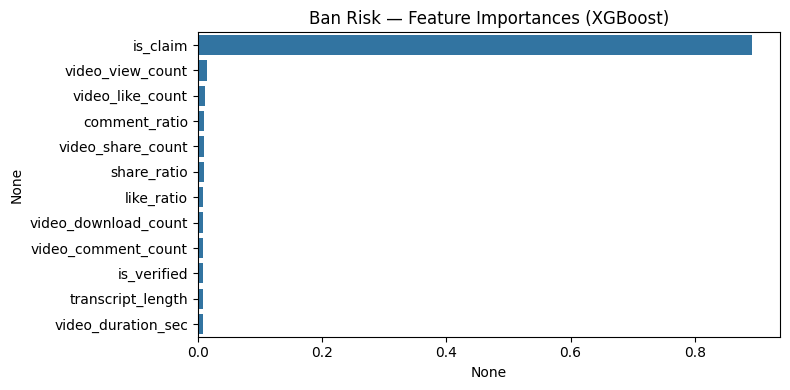

is_claim                0.892430
video_view_count        0.014256
video_like_count        0.010901
comment_ratio           0.009687
video_share_count       0.009634
share_ratio             0.009384
like_ratio              0.009134
video_download_count    0.009087
video_comment_count     0.008983
is_verified             0.008925
transcript_length       0.008808
video_duration_sec      0.008771
dtype: float32


In [101]:
# -------------------------------
# 2) Ban Risk — XGBClassifier
# -------------------------------
# Handle imbalance with scale_pos_weight = (neg / pos)
pos = (y_risk_train == 1).sum()
neg = (y_risk_train == 0).sum()
scale_pos = max(1.0, neg / max(1, pos))

xgb_risk = XGBClassifier(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    objective="binary:logistic",
    scale_pos_weight=scale_pos
)
xgb_risk.fit(X_risk_train, y_risk_train)
y_banrisk_proba_xgb = xgb_risk.predict_proba(X_risk_test)[:, 1]         
y_banrisk_pred_xgb  = (y_banrisk_proba_xgb >= 0.5).astype(int)          

print("\nBan Risk — XGBoost")
print(classification_report(y_risk_test, y_banrisk_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_risk_test, y_banrisk_pred_xgb))
try:
    auc = roc_auc_score(y_risk_test, y_banrisk_proba_xgb)
    print("ROC-AUC:", round(auc, 3))
except Exception:
    pass

# Feature importance
importances_banrisk_xgb = (
    pd.Series(xgb_risk.feature_importances_, index=X_risk_train.columns)
      .sort_values(ascending=False)
)
plt.figure(figsize=(8,4))
sns.barplot(x=importances_banrisk_xgb, y=importances_banrisk_xgb.index)
plt.title("Ban Risk — Feature Importances (XGBoost)")
plt.tight_layout(); plt.show()
print(importances_banrisk_xgb)

In [ ]:
"""
2. Ban Risk (XGBoost Classifier)
Accuracy = 0.68, F1 ≈ 0.60, ROC-AUC = 0.70
→ big improvement over Logistic Regression (0.63 accuracy) and Random Forest (0.81 accuracy but terrible recall).
Precision (class 1, risky) = 0.33, Recall = 0.65 → now it actually catches risky videos much better, though precision is still low.

Feature importances:
is_claim dominates (89%).

so, moderation risk is overwhelmingly tied to whether something is a claim. 
Engagement scale matters, but far less. This aligns with intuition: claims are more likely to be flagged.
"""


Claim Detector — XGBoost
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1895
           1       1.00      0.99      1.00      1922

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

Confusion Matrix:
 [[1893    2]
 [  15 1907]]
ROC-AUC: 0.999


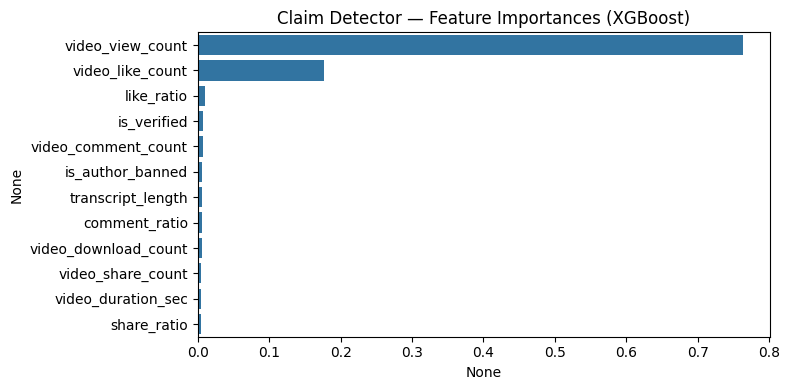

video_view_count        0.763005
video_like_count        0.177311
like_ratio              0.010369
is_verified             0.006772
video_comment_count     0.006665
is_author_banned        0.006022
transcript_length       0.005996
comment_ratio           0.005387
video_download_count    0.005382
video_share_count       0.004607
video_duration_sec      0.004298
share_ratio             0.004186
dtype: float32


In [78]:
# -------------------------------
# 3) Claim Detector — XGBClassifier
# -------------------------------
xgb_claim = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    objective="binary:logistic")
xgb_claim.fit(X_claim_train, y_claim_train)
y_claim_proba_xgb = xgb_claim.predict_proba(X_claim_test)[:,1]
y_claim_pred_xgb  = (y_claim_proba_xgb >= 0.5).astype(int)

print("\nClaim Detector — XGBoost")
print(classification_report(y_claim_test, y_claim_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_claim_test, y_claim_pred_xgb))
try:
    auc_c = roc_auc_score(y_claim_test, y_claim_proba_xgb)
    print("ROC-AUC:", round(auc_c, 3))
except Exception:
    pass

# Feature importance
imp_claim = pd.Series(xgb_claim.feature_importances_, index=X_claim_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=imp_claim, y=imp_claim.index)
plt.title("Claim Detector — Feature Importances (XGBoost)")
plt.tight_layout(); plt.show()
print(imp_claim)

In [ ]:
"""
3. Claim Detector (XGBoost Classifier)
Accuracy = 1.00, ROC-AUC = 0.999 → like Random Forest, near-perfect separation.

Feature importances:
video_view_count (76%) + video_like_count (18%) dominate.
Ratios and verification status contribute minimally.

so, claims vs opinions are almost trivially separated by engagement patterns — claims drive much higher reach.
"""

In [ ]:
# Pre-posting Virality Predictor (content-only)

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [132]:
# Input text = summaries (short descriptions of each video)
X_text = df[["video_transcription_text"]].copy()

# Target = engagement rate (based on likes, shares, comments)
y = df["engagement_rate"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

print("Train/Test shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Train/Test shapes: (15505, 1) (15505,) (3877, 1) (3877,)


In [133]:
# Cell 2: Text vectorization pipeline (TF-IDF -> SVD)

# TF-IDF: convert text into weighted token counts (semantics of words & phrases)
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)

# SVD: reduce sparse TF-IDF vectors into dense semantic space
svd = TruncatedSVD(n_components=100, random_state=42)

# Combine into a pipeline
text_pipeline = Pipeline([("tfidf", tfidf),("svd", svd)])

# Fit-transform train text, transform test text
X_train_svd = text_pipeline.fit_transform(X_train["video_transcription_text"])
X_test_svd  = text_pipeline.transform(X_test["video_transcription_text"])

print("Train SVD shape:", X_train_svd.shape)
print("Test SVD shape :", X_test_svd.shape)

Train SVD shape: (15505, 100)
Test SVD shape : (3877, 100)


In [134]:
# Cell 3: Train Ridge regression on semantic features
# Define model
ridge = Ridge(alpha=1.0, random_state=42)

# Train
ridge.fit(X_train_svd, y_train)

# Predict
y_pred_ridge = ridge.predict(X_test_svd)

# Evaluate
print("Topic-based Virality — Ridge baseline")
print("  RMSE:", mean_squared_error(y_test, y_pred_ridge, squared=False))
print("  MAE :", mean_absolute_error(y_test, y_pred_ridge))
print("  R^2 :", r2_score(y_test, y_pred_ridge))

Topic-based Virality — Ridge baseline
  RMSE: 0.20289491864783615
  MAE : 0.1705835398743559
  R^2 : 0.09223935338083944


C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [135]:
# Cell 4: Train XGBoost regressor on semantic features

# Define XGB model (tuned for small/medium text datasets)
xgb = XGBRegressor(n_estimators=500,max_depth=6,learning_rate=0.05,subsample=0.9,
    colsample_bytree=0.9,random_state=42,n_jobs=-1,tree_method="hist")

# Train
xgb.fit(X_train_svd, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test_svd)

# Evaluate
print("Topic-based Virality — XGBoost")
print("  RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))
print("  MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("  R^2 :", r2_score(y_test, y_pred_xgb))

Topic-based Virality — XGBoost
  RMSE: 0.20649661397092822
  MAE : 0.17006163169283803
  R^2 : 0.05972502123220813


C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [139]:
# Cell 5: Inference helper for topic-only virality (semantic) + demo
import textwrap

def _snippet(s, max_words=20, max_chars=120):
    words = s.strip().split()
    short = " ".join(words[:max_words])
    return short[:max_chars].rstrip()

# Use distribution of the TRAIN set to map raw prediction → 0–100 score
# (robust to outliers via 1%–99% clipping)
_lo = float(pd.Series(y_train).quantile(0.01))
_hi = float(pd.Series(y_train).quantile(0.99))
_eps = 1e-9

def _to_0_100(raw_pred):
    clipped = np.clip((raw_pred - _lo) / max(_hi - _lo, _eps), 0.0, 1.0)
    return float(clipped * 100.0)

"""
    Topic-only virality predictor:
      - Inputs: summary text (required), duration (optional; not used here)
      - Output: dict with id_snippet and a 0–100 'topic_score'
"""
def predict_topic_virality(text_full: str, duration_sec: float):
    # Transform with the already-fitted text pipeline, then predict with fitted XGB
    X_sem = text_pipeline.transform([text_full])
    pred_eng = xgb.predict(X_sem)[0]            # raw engagement_rate prediction (0..~1)
    topic_score = _to_0_100(pred_eng)          # calibrated 0–100 for UI

    return {
        "id_snippet": _snippet(text_full),
        "scores": {"topic_score": round(topic_score, 1)},
        "raw_pred_engagement_rate": float(pred_eng) }

In [142]:
demo_one = ("Top 5 tricks every student should know for studying smarter, not harder—backed by science.")
print(predict_topic_virality(demo_one, duration_sec=50))

{'id_snippet': 'Top 5 tricks every student should know for studying smarter, not harder—backed by science.', 'scores': {'topic_score': 37.5}, 'raw_pred_engagement_rate': 0.31519630551338196}


In [143]:
demo_two = ("This DIY life hack for organizing your room with dollar-store items is blowing up on TikTok.")
print(predict_topic_virality(demo_two, duration_sec=40))

{'id_snippet': 'This DIY life hack for organizing your room with dollar-store items is blowing up on TikTok.', 'scores': {'topic_score': 38.2}, 'raw_pred_engagement_rate': 0.32120004296302795}


In [145]:
# Cell A: Inspect label distribution & calibration thresholds

y_train_s = pd.Series(y_train).astype(float)

print("Engagement rate (train) summary:")
print(y_train_s.describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).round(4))

lo = float(y_train_s.quantile(0.01))
hi = float(y_train_s.quantile(0.99))
print(f"\nScore calibration using 1–99% quantiles:\n  LO (1%): {lo:.4f}\n  HI (99%): {hi:.4f}")
print("\nMapping examples (raw_pred → score):")
for raw in [lo, (lo*0.5+hi*0.5), hi]:
    score = np.clip((raw - lo) / max(hi - lo, 1e-9), 0, 1) * 100
    print(f"  {raw:.4f} → {score:.1f}")


Engagement rate (train) summary:
count    15505.0000
mean         0.3300
std          0.2162
min          0.0000
1%           0.0000
5%           0.0214
10%          0.0531
25%          0.1489
50%          0.3132
75%          0.4777
90%          0.6408
95%          0.7270
99%          0.8416
max          0.9324
Name: engagement_rate, dtype: float64

Score calibration using 1–99% quantiles:
  LO (1%): 0.0000
  HI (99%): 0.8416

Mapping examples (raw_pred → score):
  0.0000 → 0.0
  0.4208 → 50.0
  0.8416 → 100.0


In [146]:
# Cell B: Find top scoring summaries in test set

def batch_score_texts(texts):
    X_sem = text_pipeline.transform(texts)
    preds = xgb.predict(X_sem)
    scores = [_to_0_100(p) for p in preds]
    return list(zip(texts, preds, scores))

# Apply to your X_test
top_idx = np.argsort(-y_pred_xgb)[:10]   # top 10 predicted virality
top_examples = X_test.iloc[top_idx]["video_transcription_text"].tolist()
top_preds = y_pred_xgb[top_idx]

print("\nTop 10 predicted high-virality summaries:")
for t, p in zip(top_examples, top_preds):
    print(f"[score ~{_to_0_100(p):.1f}] {t[:120]}...")


Top 10 predicted high-virality summaries:
[score ~85.1] i read  in the media that losing weight alters brain activity...
[score ~79.8] a colleague learned  from the media a claim that sputnik was the first artificial satellite in space...
[score ~75.4] someone learned  from the media a claim that the people who are currently alive are only 7% of the total number of peopl...
[score ~75.0] a friend read  in the media a claim that the eiffel tower leans away from the sun...
[score ~74.6] a friend read  in a discussion board a claim that violin bows are made from horsehair...
[score ~74.6] i read a story claiming that playing dance music helps ward off mosquitoes...
[score ~74.4] i mentioned an expert revealed that the automotive industry employs about 9.9 million americans...
[score ~72.7] a colleague read  in the media that insects are attracted to light because of the moon...
[score ~72.3] a colleague learned  from the media a claim that the sunset is blue on mars...
[score ~72.1] the 

In [150]:
demo_three = ("i read a story claiming that playing dance music helps ward off mosquitoes.")
print(predict_topic_virality(demo_three, duration_sec=25))

{'id_snippet': 'i read a story claiming that playing dance music helps ward off mosquitoes.', 'scores': {'topic_score': 74.6}, 'raw_pred_engagement_rate': 0.6276500225067139}


In [ ]:
"""
This predictor = all handcrafted rule features + transcript text embeddings (TF-IDF → SVD), 
trained together in one model.

Length fit - duration_sec bucketed short/medium/long → mapped to sweet spot score.

Structure & hook - Does it open with a question? Any digit in opener? Word count in sweet band (8–24)?

Readability - Flesch Reading Ease → ideal band 60–85, penalize too low/high.

Emotion evoking - Sentiment score (VADER compound).

Balance with punctuation (not too many ! or ?).

CTA encouragement - Simple check for phrases like “follow,” “subscribe,” “check out,” or imperatives with “you.”

Banable (risk) - Claim keyword hits (claim_kw_hits), Caps ratio (spammy style), Sentiment extremes (too negative/hype).

Other useful signals:
Opening words (first 3–5 tokens).
Lexical diversity (unique words / total words).
Avg sentence length.
Emoji count.
Stopword ratio.
"""

In [153]:
import nltk

In [156]:
# Cell A: Augment summaries into transcript-like text

import random

hooks = [
    "Did you know that", 
    "Let me explain why", 
    "Here’s the crazy part:", 
    "Most people don’t realize", 
    "Experts say"
]

ctas = [
    "follow for more facts!", 
    "don’t forget to share this!", 
    "smash that like button if you agree.", 
    "comment your thoughts below!"
]

def augment_summary_to_transcript(summary: str) -> str:
    # Pick random hook + CTA
    hook = random.choice(hooks)
    cta  = random.choice(ctas)
    
    # Add filler sentences to simulate longer transcript
    filler = [
        "This is something people often misunderstand.",
        "It might sound unbelievable, but it’s true.",
        "Let’s break this down step by step.",
        "Think about how this changes our perspective.",
        "That’s why researchers are still debating it."
    ]
    filler_sentences = " ".join(random.sample(filler, k=2))
    
    # Build pseudo transcript
    transcript = f"{hook} {summary}. {filler_sentences} {cta}"
    return transcript

# Apply augmentation
df["transcript_aug"] = df["video_transcription_text"].apply(augment_summary_to_transcript)

# Peek at results
df[["video_transcription_text", "transcript_aug"]].head(3)

,video_transcription_text,transcript_aug
0,someone shared with me that drone deliveries a...,Let me explain why someone shared with me that...
1,someone shared with me that there are more mic...,Did you know that someone shared with me that ...
2,someone shared with me that american industria...,Here’s the crazy part: someone shared with me ...


In [157]:
# Cell 1: Feature engineering for full-transcript virality predictor
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import textstat

# --- Init sentiment analyzer ---
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words("english"))

# --- Helper functions ---
def count_nums(s): 
    return len(re.findall(r"\d+", s))

def pct_caps(s):
    letters = [c for c in s if c.isalpha()]
    return (sum(1 for c in letters if c.isupper()) / len(letters)) if letters else 0.0

def count_char(s, ch):
    return s.count(ch)

claim_words = ["claim","prove","evidence","debunk","fact","hoax","discovered",
               "revealed","study","scientists","experts","official","breaking",
               "viral","fake","true","false"]

def claim_hits(s):
    s_low = s.lower()
    return sum(w in s_low for w in claim_words)

def lexical_diversity(s):
    tokens = re.findall(r"\b\w+\b", s.lower())
    return len(set(tokens)) / len(tokens) if tokens else 0.0

def avg_sentence_len(s):
    sentences = re.split(r"[.!?]+", s)
    lengths = [len(re.findall(r"\w+", sen)) for sen in sentences if sen.strip()]
    return np.mean(lengths) if lengths else 0.0

def emoji_count(s):
    return sum(1 for ch in s if ch in emoji.UNICODE_EMOJI["en"])

def stopword_ratio(s):
    tokens = re.findall(r"\b\w+\b", s.lower())
    if not tokens: return 0.0
    sw_count = sum(1 for t in tokens if t in stop_words)
    return sw_count / len(tokens)

def opening_words(s, n=5):
    tokens = re.findall(r"\b\w+\b", s.lower())
    return " ".join(tokens[:n])

# --- Core engineered features ---
df["transcript_length"] = df["transcript_aug"].apply(len)
df["num_tokens_est"]   = df["transcript_aug"].str.split().apply(len)
df["num_exclam"]       = df["transcript_aug"].apply(lambda s: count_char(s,"!"))
df["num_question"]     = df["transcript_aug"].apply(lambda s: count_char(s,"?"))
df["num_digits"]       = df["transcript_aug"].apply(count_nums)
df["caps_ratio"]       = df["transcript_aug"].apply(pct_caps)
df["claim_kw_hits"]    = df["transcript_aug"].apply(claim_hits)

# Readability (Flesch)
df["readability"] = df["transcript_aug"].apply(lambda s: textstat.flesch_reading_ease(s))

# Sentiment (compound score)
df["sentiment"] = df["transcript_aug"].apply(lambda s: sia.polarity_scores(s)["compound"])

# Extras
df["lexical_diversity"] = df["transcript_aug"].apply(lexical_diversity)
df["avg_sentence_len"]  = df["transcript_aug"].apply(avg_sentence_len)
df["stopword_ratio"]    = df["transcript_aug"].apply(stopword_ratio)
df["opening_words"]     = df["transcript_aug"].apply(opening_words)

# Collect numeric features
rule_features_full = ["video_duration_sec","transcript_length","num_tokens_est","num_exclam","num_question",
                      "num_digits","caps_ratio","claim_kw_hits","readability","sentiment","lexical_diversity",
                      "avg_sentence_len","stopword_ratio"]

print("Rule-based features ready:", rule_features_full)
df[rule_features_full].head(3)

Rule-based features ready: ['video_duration_sec', 'transcript_length', 'num_tokens_est', 'num_exclam', 'num_question', 'num_digits', 'caps_ratio', 'claim_kw_hits', 'readability', 'sentiment', 'lexical_diversity', 'avg_sentence_len', 'stopword_ratio']


,video_duration_sec,transcript_length,num_tokens_est,num_exclam,num_question,num_digits,caps_ratio,claim_kw_hits,readability,sentiment,lexical_diversity,avg_sentence_len,stopword_ratio
0,59,226,38,1,0,1,0.016854,1,74.745132,0.7263,0.850000,10.00,0.475000
1,32,245,41,1,0,0,0.015152,1,72.626372,0.7345,0.860465,10.75,0.581395
2,31,269,46,1,0,2,0.014634,1,71.940761,0.7745,0.860000,12.50,0.440000


In [158]:
# Cell 2: Preprocessing pipeline (text embeddings + rule features)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# --- Define text pipeline ---
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2),min_df=2)
svd = TruncatedSVD(n_components=100, random_state=42)  # compress to 100 semantic dims
text_pipeline = Pipeline([("tfidf", tfidf), ("svd", svd)])

# --- Define numeric pipeline (rule-based features) ---
num_pipeline = Pipeline([("scaler", StandardScaler())])

# --- Combine into ColumnTransformer ---
preprocess_full = ColumnTransformer(
    transformers=[("text", text_pipeline, "transcript_aug"),("rules", num_pipeline, rule_features_full)],
    remainder="drop")

print("Preprocessing pipeline ready: text (TF-IDF+SVD) + rule features (scaled).")

Preprocessing pipeline ready: text (TF-IDF+SVD) + rule features (scaled).


In [160]:
# Train XGBoost regressor with augmented transcripts

from xgboost import XGBRegressor

# Define pipeline: preprocessing + XGB model
xgb_full = Pipeline([("prep", preprocess_full),
                     ("model", XGBRegressor(n_estimators=600,max_depth=6,learning_rate=0.05,subsample=0.9,
                                            colsample_bytree=0.9,random_state=42,n_jobs=-1,tree_method="hist"))
                    ])

# Train-test split (same as Ridge for fair comparison)
X = df[["transcript_aug"] + rule_features_full]
y = df["engagement_rate"]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit
xgb_full.fit(X_train_full, y_train_full)

# Predict
y_pred_xgb_full = xgb_full.predict(X_test_full)

# Evaluate
print("Full Transcript Virality — XGBoost (with augmented transcripts)")
print("  RMSE:", mean_squared_error(y_test_full, y_pred_xgb_full, squared=False))
print("  MAE :", mean_absolute_error(y_test_full, y_pred_xgb_full))
print("  R^2 :", r2_score(y_test_full, y_pred_xgb_full))

Full Transcript Virality — XGBoost (with augmented transcripts)
  RMSE: 0.20586471611836188
  MAE : 0.1705727158189898
  R^2 : 0.0654708651078193


C:\Users\veera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [162]:
# Inference helper for full-transcript virality predictor
def _snippet(s, max_words=20, max_chars=120):
    words = s.strip().split()
    short = " ".join(words[:max_words])
    return short[:max_chars].rstrip()

# Use training distribution to map raw prediction → 0–100 score
_lo = float(pd.Series(y_train_full).quantile(0.01))
_hi = float(pd.Series(y_train_full).quantile(0.99))
_eps = 1e-9

def _to_0_100(raw_pred):
    clipped = np.clip((raw_pred - _lo) / max(_hi - _lo, _eps), 0.0, 1.0)
    return float(clipped * 100.0)

def predict_full_virality(transcript_text: str, duration_sec):
    """
    Full-transcript virality predictor:
      - Inputs: transcript text (string), duration (optional)
      - Output: dict with snippet + 0–100 virality score
    """
    # Build input row
    row = pd.DataFrame([{"transcript_aug": transcript_text,
        "video_duration_sec": duration_sec if duration_sec else 30,
        **{feat: 0 for feat in rule_features_full if feat != "video_duration_sec"}
        }])
    
    # Fill engineered features again 
    row["transcript_length"] = len(transcript_text)
    row["num_tokens_est"] = len(transcript_text.split())
    row["num_exclam"] = transcript_text.count("!")
    row["num_question"] = transcript_text.count("?")
    row["num_digits"] = len(re.findall(r"\d+", transcript_text))
    row["caps_ratio"] = pct_caps(transcript_text)
    row["claim_kw_hits"] = claim_hits(transcript_text)
    row["readability"] = textstat.flesch_reading_ease(transcript_text)
    row["sentiment"] = sia.polarity_scores(transcript_text)["compound"]
    row["lexical_diversity"] = lexical_diversity(transcript_text)
    row["avg_sentence_len"] = avg_sentence_len(transcript_text)
    row["stopword_ratio"] = stopword_ratio(transcript_text)

    # Predict
    raw_pred = xgb_full.predict(row)[0]
    score = _to_0_100(raw_pred)

    return {"id_snippet": _snippet(transcript_text),
        "scores": {"full_transcript_score": round(score, 1)},
        "raw_pred_engagement_rate": float(raw_pred)}

In [164]:
# --- Demo ---
demo_transcript = (
    "Did you know that honey never spoils? Archaeologists found jars of honey in Egyptian tombs "
    "that are still edible today! This fact blows people's minds. "
    "Follow for more surprising science facts!")
print(predict_full_virality(demo_transcript, duration_sec=28))

{'id_snippet': 'Did you know that honey never spoils? Archaeologists found jars of honey in Egyptian tombs that are still edible today!', 'scores': {'full_transcript_score': 31.4}, 'raw_pred_engagement_rate': 0.26464974880218506}


In [ ]:
"""
For the ban-risk predictor (pre-posting, rules + transcript).
Claim presence → claim_kw_hits (keywords like claim, prove, debunk, hoax, fake, etc.).
Caps ratio → fraction of uppercase letters.
Punctuation counts → num_exclam, num_question.
Sentiment (VADER) → too negative (< -0.3) or too hypey (> 0.8) is risky.
Readability (Flesch) → very low readability (hard to follow) could be flagged.
Transcript length / tokens → extremely short or long vs typical.
Optional topic words → “official,” “breaking,” “scientists,” “government,” “health” as risky triggers

"""

In [165]:
# Feature engineering for Ban Risk predictor (on summaries)

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# --- Helper functions ---
def count_nums(s): 
    return len(re.findall(r"\d+", s))

def pct_caps(s):
    letters = [c for c in s if c.isalpha()]
    return (sum(1 for c in letters if c.isupper()) / len(letters)) if letters else 0.0

def count_char(s, ch):
    return s.count(ch)

claim_words = ["claim","prove","evidence","debunk","fact","hoax","discovered",
               "revealed","study","scientists","experts","official","breaking",
               "viral","fake","true","false","government","health"]

def claim_hits(s):
    s_low = s.lower()
    return sum(w in s_low for w in claim_words)

# --- Features from summaries ---
df["transcript_length"] = df["video_transcription_text"].apply(len)
df["num_tokens_est"]   = df["video_transcription_text"].str.split().apply(len)
df["num_exclam"]       = df["video_transcription_text"].apply(lambda s: count_char(s,"!"))
df["num_question"]     = df["video_transcription_text"].apply(lambda s: count_char(s,"?"))
df["num_digits"]       = df["video_transcription_text"].apply(count_nums)
df["caps_ratio"]       = df["video_transcription_text"].apply(pct_caps)
df["claim_kw_hits"]    = df["video_transcription_text"].apply(claim_hits)

# Readability
df["readability"] = df["video_transcription_text"].apply(lambda s: textstat.flesch_reading_ease(s))

# Sentiment
df["sentiment"] = df["video_transcription_text"].apply(lambda s: sia.polarity_scores(s)["compound"])

# --- Final feature list for Ban Risk ---
ban_features = ["transcript_length","num_tokens_est","num_exclam","num_question",
    "num_digits","caps_ratio","claim_kw_hits","readability","sentiment"]

print("Ban-risk feature columns ready:", ban_features)
df[ban_features].head(3)

Ban-risk feature columns ready: ['transcript_length', 'num_tokens_est', 'num_exclam', 'num_question', 'num_digits', 'caps_ratio', 'claim_kw_hits', 'readability', 'sentiment']


,transcript_length,num_tokens_est,num_exclam,num_question,num_digits,caps_ratio,claim_kw_hits,readability,sentiment
0,97,16,0,0,1,0.0,0,53.120000,0.3400
1,107,19,0,0,0,0.0,0,62.876316,0.3818
2,137,23,0,0,2,0.0,0,43.716087,0.6369


In [166]:
# Cell 2: Preprocess summaries (TF-IDF → SVD) + scale ban-rule features, then train/test split
text_col = "video_transcription_text"

# Text → TF-IDF (uni+bi) → SVD (dense 100-D semantics)
tfidf_ban = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=2)
svd_ban   = TruncatedSVD(n_components=100, random_state=42)
text_pipe_ban = Pipeline([("tfidf", tfidf_ban), ("svd", svd_ban)])

# Numeric rule features → Standardize
num_pipe_ban = Pipeline([("scaler", StandardScaler())])

# ColumnTransformer to combine text & numeric
preprocess_ban = ColumnTransformer(
    transformers=[("text",  text_pipe_ban, text_col),("rules", num_pipe_ban,  ban_features),],
    remainder="drop")

# Target: 1 if under review or banned, else 0 (you created this earlier as ban_risk_binary)
y_ban = df["ban_risk_binary"].astype(int)

# Design matrix for split
X_ban = df[[text_col] + ban_features].copy()

X_ban_train, X_ban_test, y_ban_train, y_ban_test = train_test_split(X_ban, y_ban, test_size=0.2, stratify=y_ban, random_state=42)

print("Ban-risk shapes:", X_ban_train.shape, "→", y_ban_train.shape, "| Test:", X_ban_test.shape)

Ban-risk shapes: (15505, 10) → (15505,) | Test: (3877, 10)


In [167]:
#  Train Ban-Risk classifier (XGBoost) + evaluation

# Handle class imbalance
pos = int((y_ban_train == 1).sum())
neg = int((y_ban_train == 0).sum())
scale_pos = max(1.0, neg / max(pos, 1))

ban_clf = Pipeline([("prep", preprocess_ban),
                    ("model", XGBClassifier(n_estimators=600,max_depth=5,learning_rate=0.05,subsample=0.9,
                                            colsample_bytree=0.9,reg_lambda=1.0,random_state=42,n_jobs=-1,
                                            tree_method="hist",objective="binary:logistic",scale_pos_weight=scale_pos))
                   ])

# Train
ban_clf.fit(X_ban_train, y_ban_train)

# Predict (labels + probabilities)
y_ban_proba = ban_clf.predict_proba(X_ban_test)[:, 1]
y_ban_pred  = (y_ban_proba >= 0.5).astype(int)   # default threshold at 0.5

# Evaluate
print("Ban Risk — XGBoost (summaries + rules)")
print(classification_report(y_ban_test, y_ban_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_ban_test, y_ban_pred))

auc = roc_auc_score(y_ban_test, y_ban_proba)
print("ROC-AUC:", round(auc, 3))


Ban Risk — XGBoost (summaries + rules)
              precision    recall  f1-score   support

           0      0.857     0.756     0.803      3133
           1      0.313     0.468     0.375       744

    accuracy                          0.701      3877
   macro avg      0.585     0.612     0.589      3877
weighted avg      0.752     0.701     0.721      3877

Confusion Matrix:
 [[2369  764]
 [ 396  348]]
ROC-AUC: 0.682


In [ ]:
"""
Accuracy ~70% → decent overall.
Class 0 (Safe): Precision 0.857, Recall 0.756 → it’s very good at identifying safe videos.
Class 1 (Risky): Precision 0.313, Recall 0.468 → catches ~47% of risky videos, but with many false positives.
ROC-AUC ~0.68 → not amazing, but better than random guessing (0.5).


The model is conservative → better at predicting safe content, weaker at detecting risky claims.
This is expected, because you’re training on summaries only, which miss the stylistic cues 
(caps, hype punctuation, CTAs) that often trigger bans.
"""

In [168]:
# Cell 4: Inference helper for Ban-Risk predictor (summaries + rules)

def _ban_snippet(s, max_words=20, max_chars=120):
    words = s.strip().split()
    short = " ".join(words[:max_words])
    return short[:max_chars].rstrip()

def predict_ban_risk(text_summary: str, threshold: float = 0.35):
    """
    Predict pre-posting ban risk from a summary (no post metrics).
    threshold: probability cutoff for labeling 'Risky' (default 0.35 to favor recall).
    Returns dict with snippet, label, probability.
    """
    # Recompute the same rule features used in training (Cell 1)
    row = pd.DataFrame([{
        "video_transcription_text": text_summary,
        "transcript_length": len(text_summary),
        "num_tokens_est": len(text_summary.split()),
        "num_exclam": text_summary.count("!"),
        "num_question": text_summary.count("?"),
        "num_digits": len(re.findall(r"\d+", text_summary)),
        "caps_ratio": pct_caps(text_summary),
        "claim_kw_hits": claim_hits(text_summary),
        "readability": textstat.flesch_reading_ease(text_summary),
        "sentiment": sia.polarity_scores(text_summary)["compound"],
    }])[["video_transcription_text"] + ban_features] 

    # Predict probability of Risky (class 1)
    proba_risky = float(ban_clf.predict_proba(row)[:, 1][0])
    label = "Risky" if proba_risky >= threshold else "Safe"

    return {"id_snippet": _ban_snippet(text_summary),
            "banable": {"label": label,"probability": round(proba_risky, 3),"threshold": threshold}}

In [169]:
# --- Demo ---
demo_summary = ("A report claims scientists revealed a shocking truth about a viral health hack, "
                 "but officials say the footage is fake.")
print(predict_ban_risk(demo_summary))

{'id_snippet': 'A report claims scientists revealed a shocking truth about a viral health hack, but officials say the footage is fake.', 'banable': {'label': 'Safe', 'probability': 0.25, 'threshold': 0.35}}
